<a href="https://colab.research.google.com/github/Ganesh-Esc/Machine-Learning---K-Nearest-Negihbor-Classification/blob/main/lab5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab: K-Nearest Neighbors Classifier

*   Use K-Nearest neighbors to classify data
*   Apply KNN classifier on a real world data set


## Import the libraries

First, to make sure that all required libraries are available, run the cell below.


In [1]:
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install scikit-learn
!pip install seaborn

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
%matplotlib inline

<div id="about_dataset">
    <h2>About the data set</h2>
</div>

Imagine a telecommunications provider has segmented its customer base by service usage patterns, categorizing the customers into four groups. If demographic data can be used to predict group membership, the company can customize offers for individual prospective customers. It is a classification problem. That is, given the dataset,  with predefined labels, we need to build a model to be used to predict class of a new or unknown case.

The example focuses on using demographic data, such as region, age, and marital, to predict usage patterns.

The target field, called **custcat**, has four possible service categories that correspond to the four customer groups, as follows:

1. Basic Service
2. E-Service
3. Plus Service
4. Total Service

Our objective is to build a classifier to predict the service category for unknown cases. We will use a specific type of classification called K-nearest neighbors.


### Load Data

In [3]:
df = pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%203/data/teleCust1000t.csv')
df.head()

,region,tenure,age,marital,address,income,ed,employ,retire,gender,reside,custcat
0,2,13,44,1,9,64.0,4,5,0.0,0,2,1
1,3,11,33,1,7,136.0,5,5,0.0,0,6,4
2,3,68,52,1,24,116.0,1,29,0.0,1,2,3
3,2,33,33,0,12,33.0,2,0,0.0,1,1,1
4,2,23,30,1,9,30.0,1,2,0.0,0,4,3


<div id="visualization_analysis">
    <h2>Data Visualization and Analysis</h2>
</div>


In [4]:
df['custcat'].value_counts()

,count
custcat,
3,281
1,266
4,236
2,217


Hence, we can say that we have records of 281 customers who opt for Plus Services, 266 for Basic-services, 236 for Total Services, and 217 for E-Services. It can thus be seen that the data set is mostly balanced between the different classes and requires no special means of accounting for class bias.


We can also visualize the correlation map of the data set to determine how the different features are related to each other.

<Axes: >

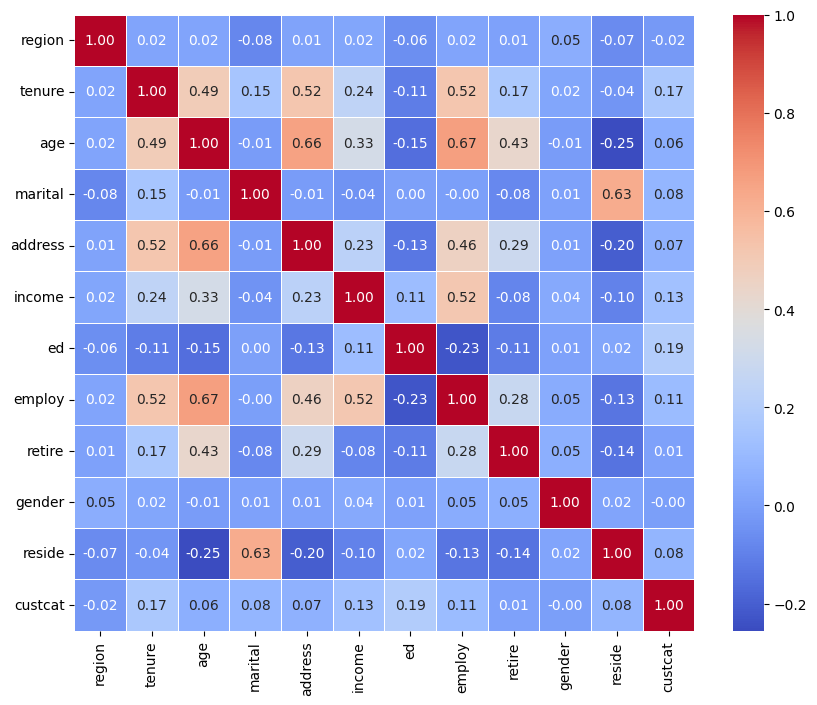

In [5]:
correlation_matrix = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

As is visible from the correlation map, some features have beeter correlation among them than others, basically indicating the depth of relationship between the two features. What is of interest to us is the correlation of the target feature, i.e. `custcat` with all the other features. This will help us identify which features should be focussed on for modeling and which ones can be ignored.

The following code snippet will give us a list of features sorted in the descending order of their absolute correlation values with respect to the target field.

In [6]:
correlation_values = abs(df.corr()['custcat'].drop('custcat')).sort_values(ascending=False)
correlation_values

,custcat
ed,0.193864
tenure,0.166691
income,0.134525
employ,0.110011
marital,0.083836
reside,0.082022
address,0.067913
age,0.056909
region,0.023771
retire,0.008908


This shows us that the features `retire` and `gender` have the least effect on `custcat` while `ed` and `tenure` have the most effect.

### Separate the input and target features


In [7]:
X = df.drop('custcat',axis=1)
y = df['custcat']

In [8]:
X

,region,tenure,age,marital,address,income,ed,employ,retire,gender,reside
0,2,13,44,1,9,64.0,4,5,0.0,0,2
1,3,11,33,1,7,136.0,5,5,0.0,0,6
2,3,68,52,1,24,116.0,1,29,0.0,1,2
3,2,33,33,0,12,33.0,2,0,0.0,1,1
4,2,23,30,1,9,30.0,1,2,0.0,0,4
...,...,...,...,...,...,...,...,...,...,...,...
995,3,10,39,0,0,27.0,3,0,0.0,1,3
996,1,7,34,0,2,22.0,5,5,0.0,1,1
997,3,67,59,0,40,944.0,5,33,0.0,1,1
998,3,70,49,0,18,87.0,2,22,0.0,1,1


In [9]:
y

,custcat
0,1
1,4
2,3
3,1
4,3
...,...
995,1
996,1
997,4
998,3


## Normalize Data

Data normalization is important for the KNN model.

KNN makes predictions based on the distance between data points (samples), i.e. for a given test point, the algorithm finds the k-nearest neighbors by measuring the distance between the test point and other data points in the dataset. By normalizing / standardizing the data, you ensure that all features contribute equally to the distance calculation. Since normalization scales each feature to have zero mean and unit variance, it puts all features on the same scale (with no feature dominating due to its larger range).

This helps KNN make better decisions based on the actual relationships between features, not just on the magnitude of their values.

In [10]:
X_norm = StandardScaler().fit_transform(X)

In [11]:
X_norm

array([[-0.02696767, -1.055125  ,  0.18450456, ..., -0.22207644,
        -1.03459817, -0.23065004],
       [ 1.19883553, -1.14880563, -0.69181243, ..., -0.22207644,
        -1.03459817,  2.55666158],
       [ 1.19883553,  1.52109247,  0.82182601, ..., -0.22207644,
         0.96655883, -0.23065004],
       ...,
       [ 1.19883553,  1.47425216,  1.37948227, ..., -0.22207644,
         0.96655883, -0.92747794],
       [ 1.19883553,  1.61477311,  0.58283046, ..., -0.22207644,
         0.96655883, -0.92747794],
       [ 1.19883553,  0.67796676, -0.45281689, ..., -0.22207644,
         0.96655883,  0.46617787]])

### Train Test Split

Now, you should separate the training and the testing data. You can retain 20% of the data for testing purposes and use the rest for training. Assigning a random state ensures reproducibility of the results across multiple executions.


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.3, random_state=42)

## KNN Classification


### Training
Initially, you may start by using a small value as the value of k

In [15]:
k = 3
#Train Model and Predict
knn_classifier = KNeighborsClassifier(n_neighbors=k)
knn_model = knn_classifier.fit(X_train,y_train)

### Predicting
Once the model is trained, we can now use this model to generate predictions for the test set.


In [16]:
yhat = knn_model.predict(X_test)

### Accuracy evaluation

In multilabel classification, **accuracy classification score** is a function that computes subset accuracy. This function is equal to the jaccard_score function. Essentially, it calculates how closely the actual labels and predicted labels are matched in the test set.


In [17]:
print("Test set Accuracy: ", accuracy_score(y_test, yhat))

Test set Accuracy:  0.32666666666666666


### Choosing the correct value of k

K in KNN, is the number of nearest neighbors to examine. However, the choice of the value of 'k' clearly affects the model. Therefore, the appropriate choice of the value of the variable `k` becomes an important task. The general way of doing this is to train the model on a set of different values of k and noting the performance of the trained model on the testing set. The model with the best value of `accuracy_score` is the one with the ideal value of the parameter k.

Check the performance of the model for 10 values of k, ranging from 1-9. You can evaluate the accuracy along with the standard deviation of the accuracy as well to get a holistic picture of the model performance.

In [18]:
Ks = 10
acc = np.zeros((Ks))
std_acc = np.zeros((Ks))
for n in range(1,Ks+1):
    #Train Model and Predict
    knn_model_n = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat = knn_model_n.predict(X_test)
    acc[n-1] = accuracy_score(y_test, yhat)
    std_acc[n-1] = np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

### Plot the model accuracy for a different number of neighbors.
Now, you can plot the model accuracy and the standard deviation to identify the model with the most suited value of k.

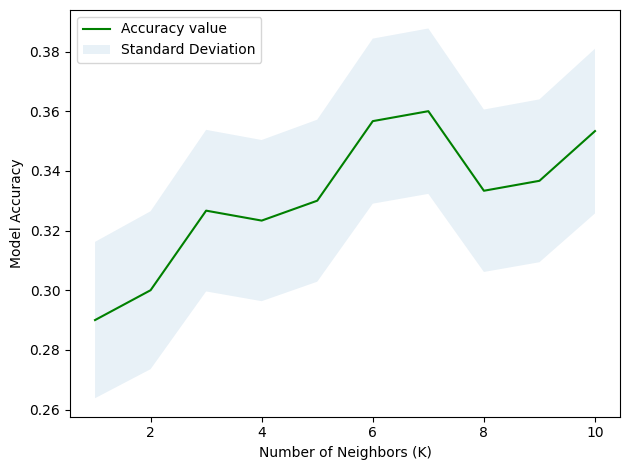

In [19]:
plt.plot(range(1,Ks+1),acc,'g')
plt.fill_between(range(1,Ks+1),acc - 1 * std_acc,acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy value', 'Standard Deviation'))
plt.ylabel('Model Accuracy')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

In [20]:
print( "The best accuracy was with", acc.max(), "with k =", acc.argmax()+1)

The best accuracy was with 0.36 with k = 7


However, since this graph is still rising, there can be a chance that the model will give a better performance with an even higher value of k.